In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F
torch.manual_seed(1337)


In [2]:
## Helping functions
# data loading
def get_batch(train_data , split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(train_data):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(train_data , split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out



In [3]:
### Set up the components of the Decoder block: 
# * MultiHeadAttention
# * FeedForward Network

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size , dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd , dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head ,dropout ):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.head_size = self.n_embd // self.n_head
        self.sa = MultiHeadAttention(self.n_head, self.head_size , self.dropout)
        self.ffwd = FeedFoward(self.n_embd ,self.dropout )
        self.ln1 = nn.LayerNorm(self.n_embd)
        self.ln2 = nn.LayerNorm(self.n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x
    
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self , vocab_size ,block_size , n_embd ,  n_head , n_layer , dropout):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
        self.dropout = dropout
        self.block = Block(self.n_embd, self.n_head , self.dropout)
        self.token_embedding_table = nn.Embedding( self.vocab_size, self.n_embd)
        self.position_embedding_table = nn.Embedding(self.block_size, self.n_embd)
        self.blocks = nn.Sequential(*[ self.block for _ in range(self.n_layer)])
        self.ln_f = nn.LayerNorm(self.n_embd) # final layer norm
        self.lm_head = nn.Linear(self.n_embd,  self.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T, self.vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



# Homework
## Part 1

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      


Step 0: train_loss: 4.053386211395264, val_loss: 4.065342426300049, train_perplexity: 57.59214782714844, val_perplexity: 58.28486251831055
Step 100: train_loss: 2.698715925216675, val_loss: 2.7093067169189453, train_perplexity: 14.860637664794922, val_perplexity: 15.01885986328125
Step 200: train_loss: 2.556312084197998, val_loss: 2.5538010597229004, train_perplexity: 12.888198852539062, val_perplexity: 12.855876922607422
Step 300: train_loss: 2.4787588119506836, val_loss: 2.4846854209899902, train_perplexity: 11.92645263671875, val_perplexity: 11.997345924377441
Step 400: train_loss: 2.4162161350250244, val_loss: 2.4217793941497803, train_perplexity: 11.203387260437012, val_perplexity: 11.265888214111328
Step 500: train_loss: 2.3686368465423584, val_loss: 2.372878074645996, train_perplexity: 10.682820320129395, val_perplexity: 10.728224754333496
Step 600: train_loss: 2.3082234859466553, val_loss: 2.3293075561523438, train_perplexity: 10.056543350219727, val_perplexity: 10.270827293395

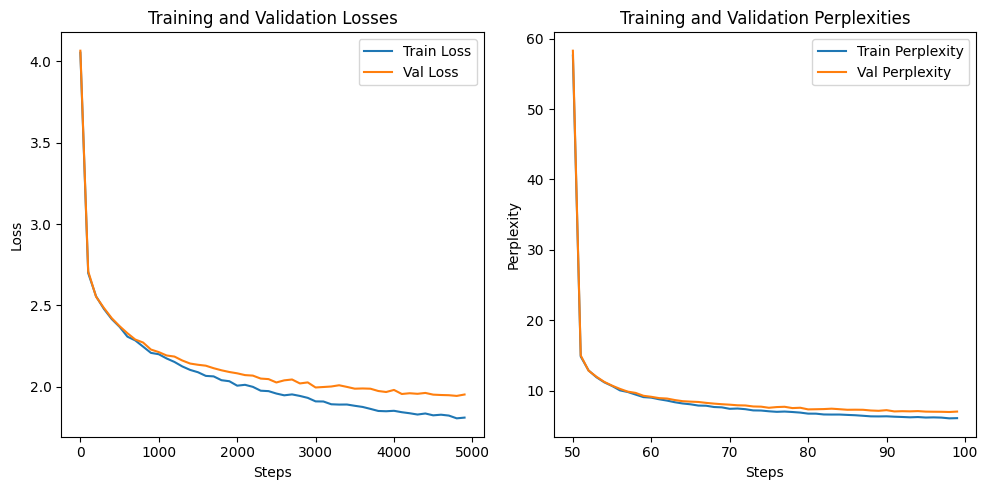

In [4]:
# Define the model, optimizer, etc.
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
dropout = 0.0
# ------------

vocab_size = 65


### Load in data and create train and test datasets

with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Training loop
train_losses = []
val_losses = []

train_perplexities = []
val_perplexities = []

# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

# Initialize model
model = LanguageModel(vocab_size ,block_size, n_embd , n_head , n_layer , dropout)
model.to(device)

token_embedding_table = nn.Embedding(vocab_size, n_embd)
position_embedding_table = nn.Embedding(block_size, n_embd)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(max_iters):
    optimizer.zero_grad()
    X, Y = get_batch(train_data , 'train')
    logits, loss = model(X, Y)
    loss.backward()
    optimizer.step()

    if i % eval_interval == 0:
        train_loss, val_loss = estimate_loss(train_data).values()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_perplexity = torch.exp(train_loss)
        val_perplexity = torch.exp(val_loss)
        train_perplexities.append(train_perplexity)
        val_perplexities.append(val_perplexity)
        print(f"Step {i}: train_loss: {train_loss}, val_loss: {val_loss}, train_perplexity: {train_perplexity}, val_perplexity: {val_perplexity}")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, max_iters, eval_interval), train_losses, label='Train Loss')
plt.plot(range(0, max_iters, eval_interval), val_losses, label='Val Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plot the training and validation perplexities
plt.subplot(1, 2, 2)
plt.plot(range(len(train_perplexities), eval_interval), train_perplexities, label='Train Perplexity')
plt.plot(range(len(val_perplexities) , eval_interval), val_perplexities, label='Val Perplexity')
plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.legend()
plt.title('Training and Validation Perplexities')


plt.tight_layout()
plt.show()
plt.close()


With increasing number of iterations, the loss and perplexty values decrease which means the model works well with both training and validation datasets.

## Part 2
2. Run the same training loop but modify one of the hyperparameters from this list: 

In [5]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

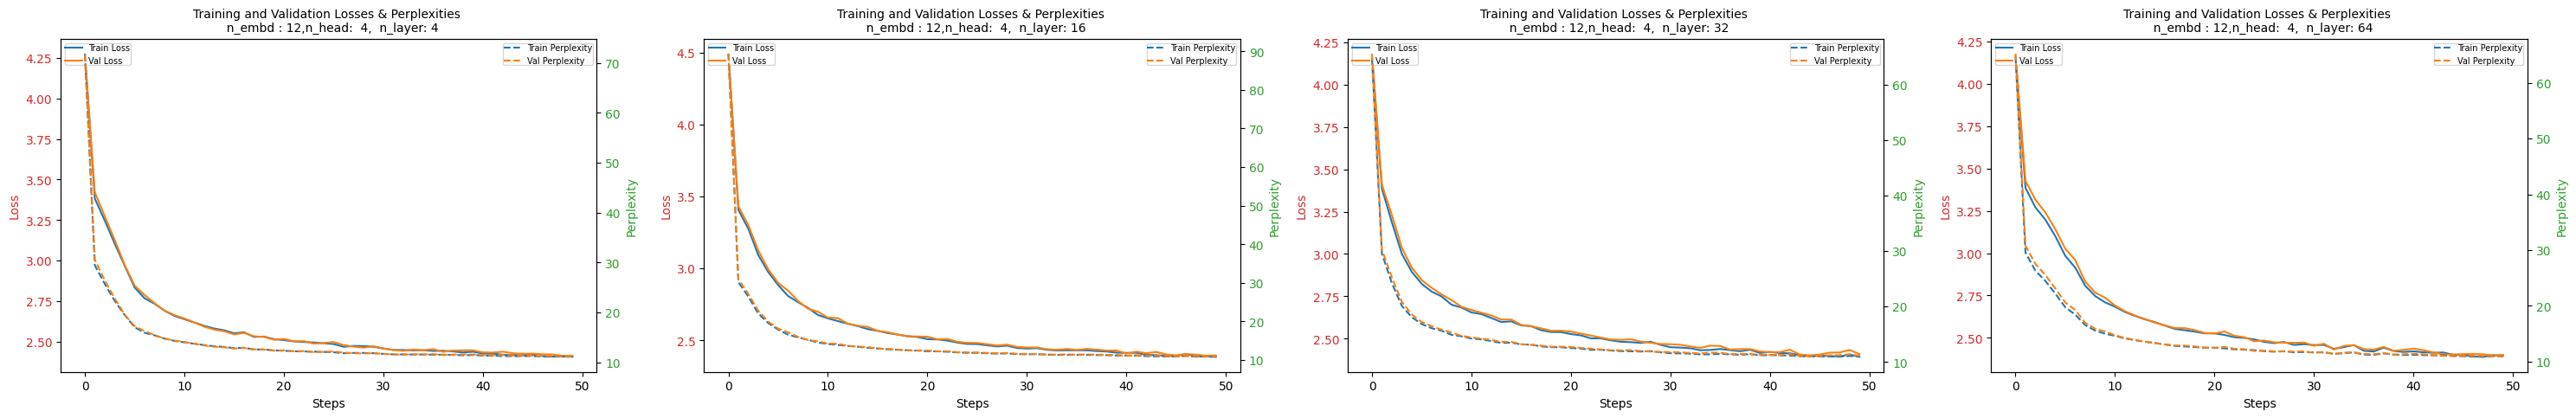

In [6]:
# Define the model, optimizer, etc.
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
dropout = 0.0
# ------------

vocab_size = 65


### Load in data and create train and test datasets

with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


n_embds  =  [12 , 12 , 12 , 12]
n_heads  = [4  , 4  , 4  , 4  ]
n_layers = [4  , 16  , 32  , 64  ]
# Loop over each set of hyperparameters
plt.figure(figsize=(12, 5))

for index , (n_embd,n_head ,n_layer)  in enumerate(zip(n_embds , n_heads ,n_layers)):

    # Training loop
    train_losses = []
    val_losses = []

    train_perplexities = []
    val_perplexities = []

    # Initialize model
    model = LanguageModel(vocab_size ,block_size, n_embd , n_head , n_layer , dropout)
    model.to(device)

    token_embedding_table = nn.Embedding(vocab_size, n_embd)
    position_embedding_table = nn.Embedding(block_size, n_embd)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for i in range(max_iters):
        optimizer.zero_grad()
        X, Y = get_batch(train_data , 'train')
        logits, loss = model(X, Y)
        loss.backward()
        optimizer.step()

        if i % eval_interval == 0:
            train_loss, val_loss = estimate_loss(train_data).values()
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_perplexity = torch.exp(train_loss)
            val_perplexity = torch.exp(val_loss)
            train_perplexities.append(train_perplexity)
            val_perplexities.append(val_perplexity)
            # print(f"Step {i}: Train Loss: {train_loss}, Val Loss: {val_loss}")

    x = [i for i in range(len(train_losses))]
    # Plot the training and validation losses
    ax1 = plt.subplot(1, 4, index+1)
    ax1.set_xlabel('Steps') 
    ax1.set_ylabel('Loss', color = 'tab:red') 
    ax1.plot(x, train_losses, label='Train Loss')
    ax1.plot(x, val_losses, label='Val Loss')
    ax1.tick_params(axis ='y', labelcolor = 'tab:red') 
    ax1.legend(loc='upper left' , borderpad=0.05, fontsize = 7)

    ax2 = ax1.twinx() 
    ax2.plot(x, train_perplexities, label='Train Perplexity' ,  linestyle='dashed')
    ax2.plot(x, val_perplexities, label='Val Perplexity'  ,  linestyle='dashed')
    ax2.set_ylabel('Perplexity', color = 'tab:green') 
    ax2.tick_params(axis ='y', labelcolor = 'tab:green') 
    ax2.legend(loc='upper right', borderpad=0.05, fontsize = 7)
    plt.title('Training and Validation Losses & Perplexities \n  n_embd : '+ str(n_embd)+',n_head:  '+  str(n_head)+',  n_layer: '+  str(n_layer) , fontsize = 10)

plt.subplots_adjust(right=2.5)
plt.show() 
plt.close("all",)


Bonus 1: output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others? 

Bonus 2: We saw a cool visualization of attention mechanisms with BertViz. Take a more complicated model than GPT2 such as "meta-llama/Llama-2-7b-chat-hf" and see how the attention mechanisms are different 

## References

Here are some recommendations for further reading and additional code for review.

* "The Illustrated Transformer" by Jay Alammar
* "Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)"
* "The Illustrated GPT-2 (Visualizing Transformer Language Models)"
* "A gentle introduction to positional encoding"
* "LLM Tutorial Workshop (Argonne National Laboratory)"
* "LLM Tutorial Workshop Part 2 (Argonne National Laboratory)"